# Инициализация

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D, Flatten, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, SimpleRNN
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
from tensorflow import keras
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Максимальное количество слов
num_words = 10000
# Максимальная длина комментария
max_comment_len = 50
#Число классов
num_classes = 6

# Загрузка тренировочных данных

In [27]:
train = pd.read_csv('toxicCommentsDataSet/toxicCommentsTrain.csv')

In [28]:
#Получение комментариев
comments = train['comment_text']

In [29]:
y_train = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Токенизация

In [30]:
tokenizer = Tokenizer(num_words=num_words)

In [31]:
#Обучение токенайзера
tokenizer.fit_on_texts(comments)

In [32]:
train_sequences = tokenizer.texts_to_sequences(comments)

In [33]:
x_train = pad_sequences(train_sequences, maxlen=max_comment_len)

# Загрузка тестовых данных

In [34]:
test_comments = pd.read_csv('toxicCommentsDataSet/toxicCommentsTest.csv')

In [35]:
test_labels = pd.read_csv('toxicCommentsDataSet/toxicCommentsTestLabels.csv')

In [36]:
test_full = pd.merge(test_comments, test_labels, on='id')

In [37]:
test = test_full[test_full['toxic']!=-1]

# Токенизация

In [38]:
test_sequences = tokenizer.texts_to_sequences(test['comment_text'])

In [39]:
y_test = test[['toxic',	'severe_toxic',	'obscene', 'threat',	'insult',	'identity_hate']]

In [40]:
x_test = pad_sequences(test_sequences, maxlen=max_comment_len)

# Проверка лучшей модели

In [44]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=116, input_length=max_comment_len,
                    embeddings_regularizer=keras.regularizers.l2(0.0001)))
model.add(GRU(units=12, activation='elu', kernel_regularizer=keras.regularizers.l2(0.001), return_sequences=True))
model.add(GRU(units=12, activation='elu', kernel_regularizer=keras.regularizers.l2(0.001), return_sequences=True))
model.add(GRU(units=12, activation='elu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC(name="auc"), "accuracy"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 116)           1160000   
                                                                 
 gru_7 (GRU)                 (None, 50, 12)            4680      
                                                                 
 gru_8 (GRU)                 (None, 50, 12)            936       
                                                                 
 gru_9 (GRU)                 (None, 12)                936       
                                                                 
 dense_4 (Dense)             (None, 6)                 78        
                                                                 
Total params: 1,166,630
Trainable params: 1,166,630
Non-trainable params: 0
_________________________________________________________________


In [45]:
history_model = model.fit(x_train,
                          y_train,
                          epochs=5,
                          batch_size=1024,
                          validation_split=0.2)

Epoch 1/5
125/125 [==============================] - 171s 1s/step - loss: 0.3498 - auc: 0.6342 - accuracy: 0.9873 - val_loss: 0.1577 - val_auc: 0.8989 - val_accuracy: 0.9910
Epoch 2/5
125/125 [==============================] - 225s 2s/step - loss: 0.1266 - auc: 0.9372 - accuracy: 0.9826 - val_loss: 0.1077 - val_auc: 0.9546 - val_accuracy: 0.9746
Epoch 3/5
125/125 [==============================] - 189s 2s/step - loss: 0.0989 - auc: 0.9585 - accuracy: 0.9856 - val_loss: 0.0927 - val_auc: 0.9574 - val_accuracy: 0.9919
Epoch 4/5
125/125 [==============================] - 58s 454ms/step - loss: 0.0874 - auc: 0.9641 - accuracy: 0.9922 - val_loss: 0.0844 - val_auc: 0.9632 - val_accuracy: 0.9926
Epoch 5/5
125/125 [==============================] - 147s 1s/step - loss: 0.0809 - auc: 0.9676 - accuracy: 0.9929 - val_loss: 0.0797 - val_auc: 0.9654 - val_accuracy: 0.9931


In [46]:
model.evaluate(x_test, y_test)

2000/2000 [==============================] - 50s 25ms/step - loss: 0.0959 - auc: 0.9599 - accuracy: 0.9962


[0.09585227072238922, 0.9598684906959534, 0.9961549043655396]

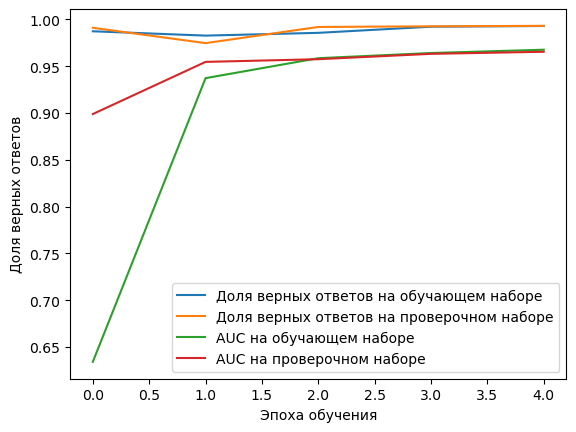

In [47]:
plt.plot(history_model.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_model.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.plot(history_model.history['auc'],
         label='AUC на обучающем наборе')
plt.plot(history_model.history['val_auc'],
         label='AUC на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()